In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import MMCIFParser, FastMMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBList
from Bio.SeqUtils import IUPACData

from loop.pdb_files import get_PDBfiles, parse_mmcif
from loop.dssp import generate_pdp_chain_pairs
from utils.common import load_tab, save_tab, dump_dicts2jsons, lower_pdbid, read_json2dict, dump_dict2json
from utils.protein import protein_letters_3to1

from utils.loops import print_loop_count
from utils.common import df2json

from domain_linker.cc_contact import contact, getCoords
from domain_linker.extract_linkers import get_2domain_start_end
from domain_linker.hbond import check_2Hbond
from params import *

from utils.log import logger

# 0. Functions

In [37]:
def clasify_interDomainLinker(df_domain_loops_dist, t_contact: int, t_hbond: int):
    '''
    classify domain-linkers from inter-domain loops. Between two domains:
    1. Num(C-C contact) < t_contact
    2. Num(Hbond) < t_hbond
    
    '''
    df_contact_t = df_domain_loops_dist[df_domain_loops_dist['num_contacts']<t_contact]
    df_independent = df_contact_t[df_contact_t['num_hbonds']<t_hbond]
    idx_independent = list(df_independent['linkerID'])
    idx_dependent = list(set(df_domain_loops_dist['linkerID']) - set(df_independent['linkerID']))
    df_dependent = df_domain_loops_dist[df_domain_loops_dist['linkerID'].isin(idx_dependent)]
    
    return df_independent, df_dependent, df_contact_t

In [2]:
def bin_count(df_independent, bins: list):
    loop_length = list(df_independent['length'])
    
    cls = [np.round(np.random.rand(),1), np.round(np.random.rand(),1),np.round(np.random.rand(),1), 0.8]
    print(cls)
    plt.figure(figsize=(12, 6))
    counts, edges, bars = plt.hist(loop_length, bins=bins, color=cls)
    
    return counts, loop_length, edges

# 1. Data

In [3]:
multi_domain = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian)
# dict_domain_loops_smoothSS_second = read_json2dict(path_loops_domain_smoothSS_second)
# after run 1_scop_domain.ipynb (adjacent domain), to generate domain distance file
df_domain_dist = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian_dist)

In [4]:
multi_domain.shape, len(multi_domain['FA-PDBID'].unique()), len(multi_domain['seq_id'].unique())

((6063, 15), 2568, 2649)

In [5]:
multi_domain[multi_domain['FA-PDBID']=='1SMY']

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,FA,FA-UNIREG-START,FA-UNIREG-END,FA-PDBREG-START,FA-PDBREG-END,FA-CHAINID,seq_id,length,experiment_type,resolution
2214,8027235,1SMY,F:258-318,Q5SKW1,258-318,4003497,258,318,258,318,F,1smy_F,61,XRay,2.7
2215,8027236,1SMY,F:319-423,Q5SKW1,319-423,4003503,319,423,319,423,F,1smy_F,105,XRay,2.7
2216,8027237,1SMY,F:74-257,Q5SKW1,74-257,4003741,74,257,74,257,F,1smy_F,184,XRay,2.7


In [6]:
len(multi_domain['FA-PDBID'].unique()), len(df_domain_dist['pdbid'].unique()), 1885+689

(2568, 2574, 2574)

## 1.1. Load more data

In [7]:
dict_all_loops_smoothSS_first = read_json2dict(path_loops_all_smoothSS_first)
dict_all_loops_smoothSS_second = read_json2dict(path_loops_all_smoothSS_second)

# dict_domain_loops_smoothSS_first = read_json2dict(path_loops_domain_smoothSS_first)
dict_domain_loops_smoothSS_second = read_json2dict(path_loops_domain_smoothSS_second)
# !!!!!!!
dict_domain_loops_hbond_contact_smoothSS_second = read_json2dict(path_loops_domain_hbond_contact_smoothSS_second)

In [8]:
sum([len(value) for key, value in dict_all_loops_smoothSS_first.items()]), sum([len(value) for key, value in dict_all_loops_smoothSS_second.items()])

(51128, 50762)

In [9]:
sum([len(v) for k, v in dict_all_loops_smoothSS_second.items()])

50762

## 1.2. Add number of H-bonds & C-C contacts to df_domain_loops_dist --  skippable

In [46]:
df_domain_loops_smoothSS_second = pd.DataFrame.from_dict(dict_domain_loops_hbond_contact_smoothSS_second, orient='index')
df_domain_loops_smoothSS_second['seq'] = [' '.join(seq) for seq in df_domain_loops_smoothSS_second['seq']]
df_domain_loops_smoothSS_second['seq_unp'] = [' '.join(seq) for seq in df_domain_loops_smoothSS_second['seq_unp']]
df_domain_loops_smoothSS_second['num_hbonds'] = [len(hbonds)//2 for hbonds in df_domain_loops_smoothSS_second['hbonds']]
df_domain_loops_smoothSS_second['num_contacts'] = [len(c_c_contacts) for c_c_contacts in df_domain_loops_smoothSS_second['c_c_contacts']]
df_domain_loops_smoothSS_second.insert(0, 'linkerID', df_domain_loops_smoothSS_second.index)
df_domain_loops_dist_smoothSS_second = df_domain_loops_smoothSS_second.merge(df_domain_dist, on=['domain1', 'domain2'], how='inner', suffixes=('_loop', '_domain'))

In [47]:
len(set(df_domain_dist['pdbid'].unique()) - set(df_domain_loops_dist_smoothSS_second['pdbid_domain'].unique()))

689

In [48]:
print(df_domain_loops_dist_smoothSS_second.shape[0]), df_domain_loops_dist_smoothSS_second.columns
# df_domain_loops_dist_smoothSS_second[:3]

2296


(None,
 Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
        'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
        'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
        'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
        'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
        'start_domain', 'end_domain', 'dist', 'missing_domain'],
       dtype='object'))

In [49]:
len(df_domain_loops_dist_smoothSS_second['pdbid_domain'].unique())

1885

In [50]:
df_domain_loops_dist_smoothSS_second[['pdbid_domain', 'chainid_domain']].drop_duplicates()

,pdbid_domain,chainid_domain
0,1A04,A
1,1A0P,A
2,1A21,A
3,1A3Q,A
4,1A45,A
...,...,...
2289,7OA5,A
2290,7PVC,A
2291,7REQ,A
2292,8RUC,A


In [51]:
len(dict_domain_loops_smoothSS_second.keys())

1945

In [52]:
# save
save_tab(df_domain_loops_dist_smoothSS_second, path_loops_domain_dist_hbond_contact_smoothSS_second)

# 2. Threshold & Length Distribution

In [53]:
df_domain_loops_dist_smoothSS_2step = load_tab(path_loops_domain_dist_hbond_contact_smoothSS_second)
df_domain_loops_dist_smoothSS_2step.shape

(2296, 29)

## 2.1. C-C contacts & Hbonds threshold -- skippable

In [54]:
t_contact = 4
t_hbond = 3
df_independent_smoothSS_2step, df_dependent_smoothSS_2step, df_contact_t_smoothSS_2step = clasify_interDomainLinker(df_domain_loops_dist_smoothSS_second, t_contact, t_hbond)

In [55]:
df_contact_t_smoothSS_2step.shape[0], df_domain_loops_dist_smoothSS_2step.shape[0]-df_contact_t_smoothSS_2step.shape[0]

(1682, 614)

In [56]:
df_independent_smoothSS_2step.shape[0], df_contact_t_smoothSS_2step.shape[0]-df_independent_smoothSS_2step.shape[0]

(1647, 35)

In [57]:
2296-1647

649

In [58]:
df_dependent_smoothSS_2step.shape[0]

649

### save

In [59]:
save_tab(df_independent_smoothSS_2step, path_independent_domain_linker)
save_tab(df_dependent_smoothSS_2step, path_dependent_domain_linker)

In [60]:
dump_dict2json(df_independent_smoothSS_2step.to_dict(orient='records'), path_independent_domain_linker_json)
dump_dict2json(df_dependent_smoothSS_2step.to_dict(orient='records'), path_dependent_domain_linker_json)

# df2json(df=df_dependent_smoothSS_2step, path_json=path_dependent_domain_linker_json)

# Plots - after run 1_scop_domain.ipynb (adjacent domain)

In [2]:
df_independent_smoothSS_2step = load_tab(path_independent_domain_linker)
df_dependent_smoothSS_2step = load_tab(path_dependent_domain_linker)

## 1. length distribution (Loops, independent/dependent)

### a. Smoothing SS

[0.7, 0.1, 0.0, 0.8]
[0.2, 0.3, 0.3, 0.8]


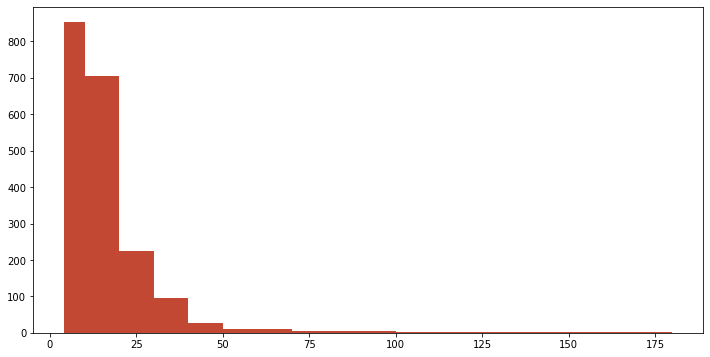

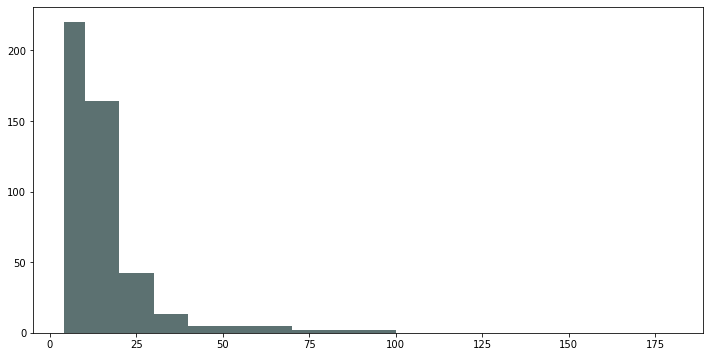

In [19]:
bins = [4, 10, 20, 30, 40, 50, 70, 100, 180]
counts_smoothSS, inter_length_smoothSS, _ = bin_count(df_independent_smoothSS_2step, bins)
counts_smoothSS_intra, intra_length_smoothSS, _ = bin_count(df_dependent_smoothSS_2step, bins)

In [20]:
min(inter_length_smoothSS), max(inter_length_smoothSS), min(intra_length_smoothSS), max(intra_length_smoothSS)

(4, 178, 4, 92)

## 2. Examples

In [45]:
df_dependent_smoothSS_2step[df_dependent_smoothSS_2step['pdbid_domain']=='1TF4']['unp_acc']

929    P26221
Name: unp_acc, dtype: object

In [21]:
df_independent_smoothSS_2step.columns

Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
       'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
       'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
       'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
       'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
       'start_domain', 'end_domain', 'dist', 'missing_domain'],
      dtype='object')

# 3. Compare different steps of smoothing

In [8]:
# df_independent_smoothSS_2step.shape

In [46]:
dict_all_loops = read_json2dict(path_loops_all)
dict_all_loops_smoothSS_first = read_json2dict(path_loops_all_smoothSS_first)
dict_all_loops_smoothSS_second = read_json2dict(path_loops_all_smoothSS_second)

multi_domain = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian)

In [47]:
dict_all_loops_smoothSS_second.keys

<function dict.keys>

## three examples

In [52]:
df_examples = df_independent_smoothSS_2step[df_independent_smoothSS_2step['pdbid_loop'].isin(['2bnm', '4b2y', '3ksy'])]

df_examples[['linkerID', 'start_loop', 'end_loop', 'pdbid_loop', 'domain1', 'domain2']]

,linkerID,start_loop,end_loop,pdbid_loop,domain1,domain2
1284,1284,63,91,2bnm,8025994,8025995
1778,1778,176,200,3ksy,8018971,8018981
1779,1779,745,780,3ksy,8018982,8018950
1913,1913,517,550,4b2y,8105234,8105284


In [49]:
df_independent_smoothSS_2step.columns

Index(['linkerID', 'start_loop', 'end_loop', 'seq_id', 'start_unp', 'end_unp',
       'seq_id_unp', 'seq', 'seq_unp', 'dssp_key_str', 'missing_loop',
       'miss_length', 'miss_percentage', 'unp_acc', 'length', 'domain1',
       'domain2', 'pdbid_loop', 'chainid_loop', 'hbonds', 'c_c_contacts',
       'num_hbonds', 'num_contacts', 'pdbid_domain', 'chainid_domain',
       'start_domain', 'end_domain', 'dist', 'missing_domain'],
      dtype='object')

In [50]:
multi_domain[multi_domain['FA-PDBID'].isin(['2BNM', '4B2Y', '5XMC'])]

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,FA,FA-UNIREG-START,FA-UNIREG-END,FA-PDBREG-START,FA-PDBREG-END,FA-CHAINID,seq_id,length,experiment_type,resolution
3210,8025994,2BNM,A:6-76,Q56185,6-76,4000896,6,76,6,76,A,2bnm_A,71,XRay,1.7
3211,8025995,2BNM,A:77-198,Q56185,77-198,4000964,77,198,77,198,A,2bnm_A,122,XRay,1.7
4953,8105234,4B2Y,A:21-546,R4GRT6,22-547,4002736,22,547,21,546,A,4b2y_A,526,XRay,1.9
4954,8105284,4B2Y,A:547-698,R4GRT6,548-699,4003754,548,699,547,698,A,4b2y_A,152,XRay,1.9
5935,8091384,5XMC,A:287-319,Q8C863,287-319,4002695,287,319,287,319,A,5xmc_A,33,XRay,2.6
5936,8091386,5XMC,A:320-381,Q8C863,320-381,4002695,320,381,320,381,A,5xmc_A,62,XRay,2.6
5937,8091388,5XMC,A:484-859,Q8C863,484-859,4002196,484,859,484,859,A,5xmc_A,376,XRay,2.6


In [51]:
# dict_all_loops_smoothSS_first['2bnm_a_Q56185'][3:]
dict_all_loops['2bnm_a']

[{'start': 1, 'end': 5, 'seq': ['M', 'S', 'N', 'T', 'K'], 'length': 5},
 {'start': 22, 'end': 25, 'seq': ['V', 'K', 'M', 'D'], 'length': 4},
 {'start': 48, 'end': 51, 'seq': ['G', 'G', 'E', 'L'], 'length': 4},
 {'start': 63, 'end': 67, 'seq': ['L', 'G', 'T', 'S', 'I'], 'length': 5},
 {'start': 71,
  'end': 78,
  'seq': ['T', 'P', 'P', 'A', 'G', 'N', 'D', 'L'],
  'length': 8},
 {'start': 83, 'end': 86, 'seq': ['I', 'I', 'Q', 'M'], 'length': 4},
 {'start': 94,
  'end': 102,
  'seq': ['K', 'G', 'V', 'R', 'D', 'N', 'V', 'D', 'Y'],
  'length': 9},
 {'start': 108,
  'end': 117,
  'seq': ['L', 'V', 'R', 'T', 'K', 'R', 'A', 'P', 'S', 'L'],
  'length': 10},
 {'start': 125, 'end': 128, 'seq': ['L', 'T', 'D', 'N'], 'length': 4},
 {'start': 132,
  'end': 141,
  'seq': ['A', 'K', 'F', 'N', 'S', 'G', 'H', 'A', 'G', 'N'],
  'length': 10},
 {'start': 156,
  'end': 161,
  'seq': ['G', 'D', 'K', 'E', 'N', 'P'],
  'length': 6},
 {'start': 167, 'end': 170, 'seq': ['P', 'T', 'G', 'A'], 'length': 4},
 {'sta

In [32]:
dict_all_loops_smoothSS_first.keys()

dict_keys(['1a04_a_P0AF28', '1a0i_a_P00969', '1a0p_a_P0A8P8', '1a21_a_P24055', '1a3q_a_Q00653', '1a45_a_P23005', '1a5j_a_Q03237', '1a65_a_Q9Y780', '1a6a_b_P01911', '1a6c_a_Q88894', '1a6q_a_P35813', '1a77_a_Q58839', '1a79_a_Q58819', '1a7i_a_Q05158', '1a81_a_P43405', '1a8d_a_P04958', '1a8p_a_Q44532', '1a8y_a_P07221', '1aa0_a_P10104', '1aay_a_P08046', '1ab4_a_P0AES4', '1abr_b_P11140', '1acc_a_P13423', '1aco_a_P20004', '1af7_a_P07801', '1afw_b_P27796', '1aip_a_P60338', '1ais_a_P62001', '1ais_b_P61999', '1aln_a_P0ABF6', '1amm_a_P02526', '1amu_a_P0C061', '1an8_a_Q8NKX2', '1aoa_a_P13797', '1aor_a_Q51739', '1aoz_a_P37064', '1aqt_a_P0A6E6', '1ati_a_P56206', '1au7_a_P10037', '1aua_a_P24280', '1aut_l_P04070', '1auv_a_P17599', '1ava_a_P04063', '1avc_a_P79134', '1aw9_a_Q9ZP62', '1axd_a_P12653', '1axi_b_P10912', '1b06_a_Q08713', '1b0n_a_P06533', '1b1x_a_O77811', '1b23_p_Q01698', '1b24_a_P21505', '1b25_a_Q8U1K3', '1b3q_a_Q56310', '1b43_a_O93634', '1b48_a_P24472', '1b4a_a_O31408', '1b63_a_P23367', '1b